In [56]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.signal import resample

from seiz_eeg.dataset import EEGDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from data.dataset import EEGDatasetWrapper

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

import wandb
from tqdm import tqdm


import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
data_root = "data/data"
data_preprocessing = "fft_filtering"
eeg_data_wrapper= EEGDatasetWrapper(
    data_root,
    data_preprocessing)

In [58]:
class EEGGraphFeatureDataset(torch.utils.data.Dataset):
    def __init__(self, eeg_dataset, window_size=100):
        self.eeg_dataset = eeg_dataset
        self.window_size = window_size

    def __len__(self):
        return len(self.eeg_dataset)

    def __getitem__(self, idx):
        signal, label = self.eeg_dataset[idx]  # signal shape: (seq_len, num_electrodes)
        features = torch.from_numpy(signal).float()  # Convert to tensor
        return features, label

In [59]:
selected_ids = eeg_data_wrapper.get_subject_ids()
validation_id = "s002" 
selected_ids.remove(validation_id)
train_dataset, val_dataset = eeg_data_wrapper.leave_one_out_split(
        validation_id, selected_ids
)

labels = train_dataset.get_label_array()
labels = np.array(labels)
# get ratio positive and negative samples
pos_ratio = np.sum(labels == 0) / np.sum(labels == 1)
print(f"Positive ratio: {pos_ratio:.2f}")

train_data_label_1 = []
train_data_label_0 = []
for i, (train_data, label) in enumerate(train_dataset):
        if label == 1:
                train_data_label_1.append((train_data, label))
        else:
                train_data_label_0.append((train_data, label))
train_data_label_1 = np.array(train_data_label_1, dtype=object)
train_data_label_0 = np.array(train_data_label_0, dtype=object)
print(f"Number of samples with label 1: {len(train_data_label_1)}")
print(f"Number of samples with label 0: {len(train_data_label_0)}")
num_samples = min(len(train_data_label_1), len(train_data_label_0))
train_data_label_0 = train_data_label_0[np.random.choice(len(train_data_label_0), num_samples, replace=False)]
train_data_label_1 = train_data_label_1[np.random.choice(len(train_data_label_1), num_samples, replace=False)]
train_dataset = np.concatenate((train_data_label_0, train_data_label_1), axis=0)
np.random.shuffle(train_dataset)

print(f"Number of samples in the training set: {len(train_dataset)}")
train_dataset = EEGGraphFeatureDataset(train_dataset, window_size=1000)
val_dataset = EEGGraphFeatureDataset(val_dataset, window_size=1000)
test_data , label = train_dataset.__getitem__(0)

print(f"Test data shape: {test_data.shape}")
print (test_data)

Positive ratio: 4.00
Number of samples with label 1: 2096
Number of samples with label 0: 8393
Number of samples in the training set: 4192
Test data shape: torch.Size([354, 19])
tensor([[6.2713, 7.5692, 8.1288,  ..., 7.7917, 6.7994, 6.3768],
        [8.3560, 7.4317, 7.5825,  ..., 8.2781, 7.2308, 5.7412],
        [8.2251, 9.0305, 7.1216,  ..., 8.0795, 6.3712, 7.3708],
        ...,
        [4.7409, 4.7025, 4.7607,  ..., 3.7579, 3.4336, 4.1821],
        [4.1295, 3.7468, 4.2741,  ..., 4.5338, 5.0754, 4.6683],
        [3.6569, 3.0343, 4.7309,  ..., 4.1315, 4.1136, 3.8522]])


In [60]:
train_loader = DataLoader(
        train_dataset, batch_size=32, shuffle=True
    )
val_loader = DataLoader(val_dataset, batch_size=32,shuffle = True)

In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.utils import dense_to_sparse


class GAT_Model(nn.Module):
    def __init__(self, input_dim, gat_hidden_dim=80, output_dim=1, gat_heads=8):
        super(GAT_Model, self).__init__()
        self.num_electrodes = 19
        self.gat_heads = gat_heads
        self.input_dim = input_dim  # num_freqs (feature per node)

        # Debug containers
        self.debug_info = {}

        # GAT 1 (per-window spatial)
        self.gat1 = GATv2Conv(in_channels=input_dim, out_channels=gat_hidden_dim, heads=gat_heads, concat=True)
        self.gat2 = GATv2Conv(in_channels=gat_hidden_dim * gat_heads, out_channels=gat_hidden_dim, heads=gat_heads, concat=True)
        # Final classifier
        self.attention_pool = nn.Linear(gat_hidden_dim * gat_heads, 1)
        self.fc = nn.Linear(gat_hidden_dim * gat_heads, output_dim)

    def build_fully_connected_graph(self, num_nodes):
        adj = torch.ones(num_nodes, num_nodes)  # fully connected
        edge_index, _ = dense_to_sparse(adj)    # includes self-loops
        return edge_index

    def forward(self, x, return_debug=False):
        """
        Args:
            x: Tensor of shape (batch_size, num_freqs, num_electrodes)
            return_debug: If True, also returns intermediate tensors for debugging
        Returns:
            logits: (batch_size,) or (logits, debug_dict)
        """
        batch_size, num_freqs, num_electrodes = x.shape
        edge_index = self.build_fully_connected_graph(num_electrodes).to(x.device)

        graph_outputs = []
        debug_info = []

        for b in range(batch_size):
            nodes = x[b].permute(1, 0)  # shape: (num_nodes, num_freqs)
            out = self.gat1(nodes, edge_index)  # shape: (num_nodes, hidden_dim)
            out = F.elu(out)  # activation function
            out = self.gat2(out, edge_index)
            attn_scores = self.attention_pool(out)  # (num_nodes, 1)
            attn_scores = torch.softmax(attn_scores, dim=0)  # (num_nodes, 1)
            pooled = (attn_scores * out).sum(dim=0)  # weighted sum
            graph_outputs.append(pooled)

        graph_outputs = torch.stack(graph_outputs, dim=0)  # (batch_size, gat_hidden_dim * gat_heads)
        logits = self.fc(graph_outputs)  # (batch_size, 1)

        return logits.squeeze(1)  # (batch_size,)


    def get_graph_embeddings(self, x):
        """
        Returns: tensor (batch_size, hidden_dim)
        """
        logits, debug = self.forward(x, return_debug=True)
        return torch.stack(debug["graph_embeddings"], dim=0)


In [62]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 5
model = GAT_Model(input_dim=354).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
pos_weight = torch.tensor([pos_ratio])
loss_fn = nn.BCEWithLogitsLoss()#pos_weight=pos_weight)


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for step, (x_batch, y_batch) in enumerate(loop):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        logits = model(x_batch)
        loss = loss_fn(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg_loss = running_loss / (step + 1)
        loop.set_postfix(loss=avg_loss)

Best threshold: 0.3131
Validation Loss: 0.6373
Accuracy: 0.6651
F1 Score: 0.5565
ROC AUC: 0.7173
Macro F1 Score: 0.6437


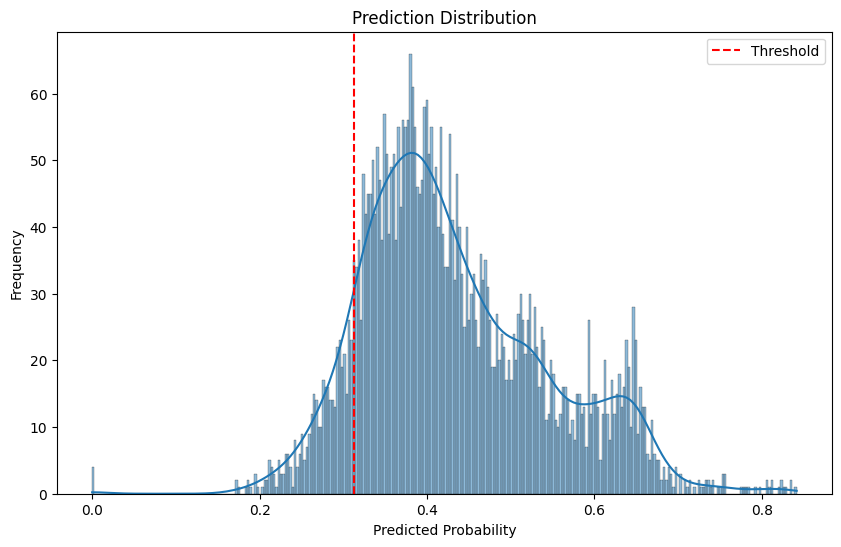

In [65]:
model.eval()
val_loss = 0.0
predictions = []
true_labels = []

with torch.no_grad():
    loop = tqdm(train_loader, desc="Validation", leave=False)
    for step, (x_batch, y_batch) in enumerate(loop):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        logits = model(x_batch)


        loss = loss_fn(logits, y_batch)
        val_loss += loss.item()

        preds = torch.sigmoid(logits).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(y_batch.cpu().numpy())

        loop.set_postfix(batch_loss=loss.item())

avg_val_loss = val_loss / len(loop)

# Metrics
predictions = np.array(predictions)
true_labels = np.array(true_labels)

from sklearn.metrics import f1_score

thresholds = np.linspace(0, 1, 100)
f1s = [f1_score(true_labels, predictions > t) for t in thresholds]
best_t = thresholds[np.argmax(f1s)]
t = 0.90
print(f"Best threshold: {best_t:.4f}")
binary_preds = (predictions > 0.5).astype(int)

accuracy = accuracy_score(true_labels, binary_preds)
f1 = f1_score(true_labels, binary_preds)
roc_auc = roc_auc_score(true_labels, predictions)

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
# print macro f1 score
macro_f1 = f1_score(true_labels, binary_preds, average='macro')
print(f"Macro F1 Score: {macro_f1:.4f}")

#plot prediction distribution
plt.figure(figsize=(10, 6))
sns.histplot(predictions, bins=300, kde=True)
plt.axvline(x=best_t, color='r', linestyle='--', label='Threshold')
plt.title('Prediction Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()


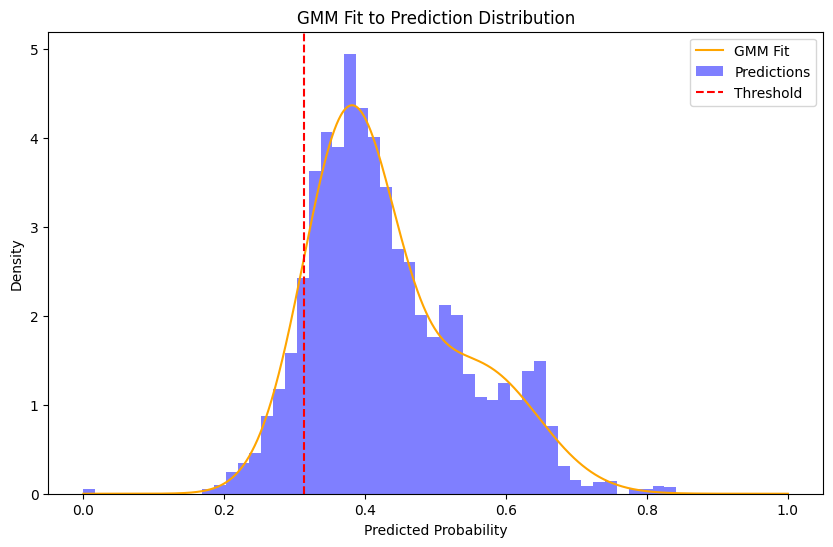

In [66]:
# fit a bidmodal gaussian using EM algorithm
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(predictions.reshape(-1, 1))
x = np.linspace(0, 1, 1000)
y = np.exp(gmm.score_samples(x.reshape(-1, 1)))
plt.figure(figsize=(10, 6))
plt.plot(x, y, label='GMM Fit', color='orange')
plt.hist(predictions, bins=50, density=True, alpha=0.5, label='Predictions', color='blue')
plt.axvline(x=best_t, color='r', linestyle='--', label='Threshold')
plt.title('GMM Fit to Prediction Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

Attention weights shape: torch.Size([1, 8, 80])


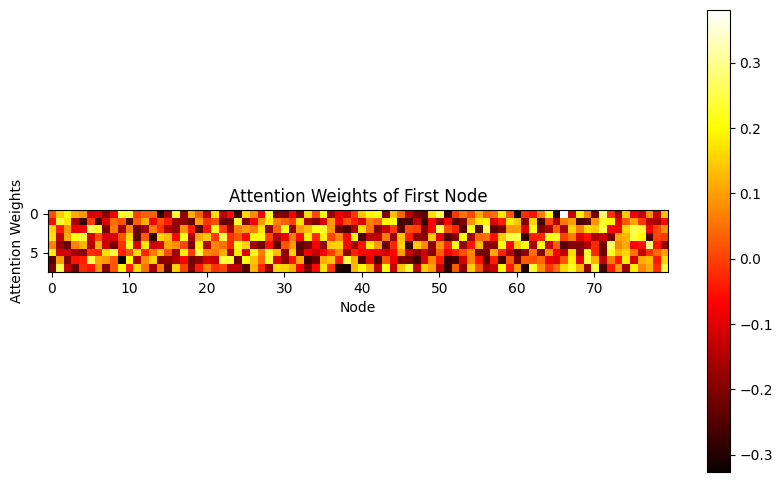

In [67]:
# print weights of model GAT 
gat = model.gat1

# get attention weights of first node
attn_weights = gat.att
print("Attention weights shape:", attn_weights.shape)

# plot attention weights
plt.figure(figsize=(10, 6))
plt.imshow(attn_weights[0].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Attention Weights of First Node')
plt.xlabel('Node')
plt.ylabel('Attention Weights')
plt.show()


In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class MLP_Model(nn.Module):
    def __init__(self, input_dim,output_dim=1, hidden_dim=32):
        super(MLP_Model, self).__init__()
        self.num_electrodes = 19
        self.input_dim = input_dim  # num_freqs (feature per node)
        # Debug containers
        self.debug_info = {}
        self.fc1 = nn.Linear(input_dim, output_dim)
        #self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        #self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, num_freqs, num_electrodes)
            return_debug: If True, also returns intermediate tensors for debugging
        Returns:
            logits: (batch_size,) or (logits, debug_dict)
        """
        batch_size, num_freqs, num_electrodes = x.shape

        logits_array = []

        for b in range(batch_size):
            nodes = x[b].permute(1, 0)  # shape: (num_nodes, num_freqs)
            out = self.fc1(nodes)  # shape: (num_nodes, hidden_dim)
            out = F.elu(out)
            #out = self.fc2(out)
            #out = F.elu(out)
            #out = self.fc3(out)
            #out = F.elu(out)
            pooled = out.mean(dim=0)            # global mean pooling → shape: (hidden_dim,)
            logits_array.append(pooled)
        logits = torch.stack(logits_array, dim=0).squeeze(-1)  # shape: (batch_size,)
        return logits



In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 5
model_mlp = MLP_Model(input_dim=354).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#    optimizer, mode='min', factor=0.5, patience=3, verbose=True
#)
#loss_fn = BinaryFocalLoss(alpha=0.75, gamma=2.0, reduction='mean')

pos_weight = torch.tensor([pos_ratio])
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    for step, (x_batch, y_batch) in enumerate(loop):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        logits = model_mlp(x_batch)
        loss = loss_fn(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        avg_loss = running_loss / (step + 1)
        loop.set_postfix(loss=avg_loss)


Best threshold: 0.7576
Validation Loss: 1.2373
Accuracy: 0.5267
F1 Score: 0.6697
ROC AUC: 0.5929
Macro F1 Score: 0.4177


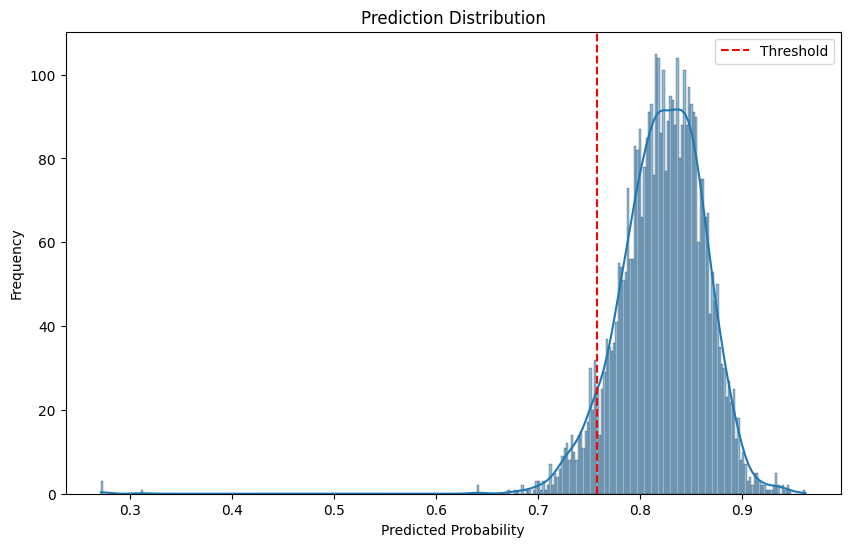

In [70]:
model_mlp.eval()
val_loss = 0.0
predictions = []
true_labels = []

with torch.no_grad():
    loop = tqdm(train_loader, desc="Validation", leave=False)
    for step, (x_batch, y_batch) in enumerate(loop):
        x_batch = x_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        logits = model_mlp(x_batch)


        loss = loss_fn(logits, y_batch)
        val_loss += loss.item()

        preds = torch.sigmoid(logits).cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(y_batch.cpu().numpy())

        loop.set_postfix(batch_loss=loss.item())

avg_val_loss = val_loss / len(loop)

# Metrics
predictions = np.array(predictions)
true_labels = np.array(true_labels)

from sklearn.metrics import f1_score

thresholds = np.linspace(0, 1, 100)
f1s = [f1_score(true_labels, predictions > t) for t in thresholds]
best_t = thresholds[np.argmax(f1s)]
t = 0.90
print(f"Best threshold: {best_t:.4f}")
binary_preds = (predictions > best_t).astype(int)

accuracy = accuracy_score(true_labels, binary_preds)
f1 = f1_score(true_labels, binary_preds)
roc_auc = roc_auc_score(true_labels, predictions)

print(f"Validation Loss: {avg_val_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
# print macro f1 score
macro_f1 = f1_score(true_labels, binary_preds, average='macro')
print(f"Macro F1 Score: {macro_f1:.4f}")

#plot prediction distribution
plt.figure(figsize=(10, 6))
sns.histplot(predictions, bins=300, kde=True)
plt.axvline(x=best_t, color='r', linestyle='--', label='Threshold')
plt.title('Prediction Distribution')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.legend()
plt.show()
